## Super resolution

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [6]:
path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [3]:
il = ImageList.from_folder(path_hr)

In [4]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [7]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [9]:
data = get_data(bs,size)

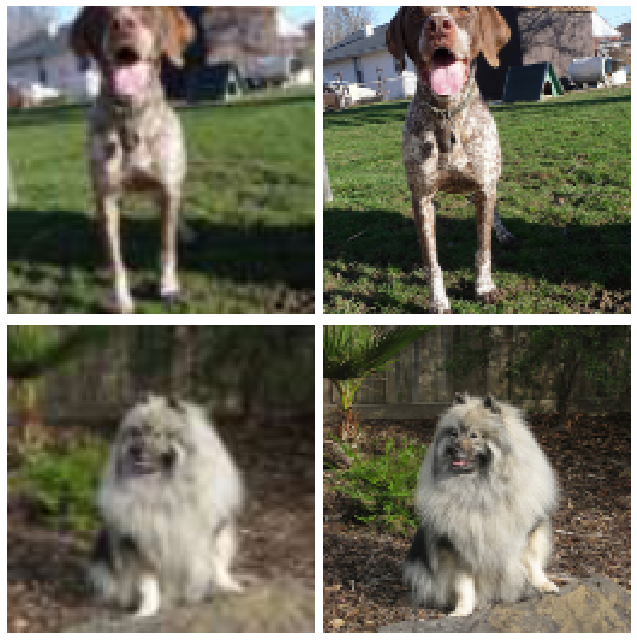

In [11]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [12]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [13]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [14]:
gram_matrix(t)

tensor([[[0.0660, 0.0650, 0.0551],
         [0.0650, 0.0655, 0.0546],
         [0.0551, 0.0546, 0.0485]],

        [[0.0660, 0.0650, 0.0551],
         [0.0650, 0.0655, 0.0546],
         [0.0551, 0.0546, 0.0485]]])

In [15]:
base_loss = F.l1_loss

In [16]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/jupyter/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 66.6MB/s] 


In [17]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [18]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [19]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [20]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


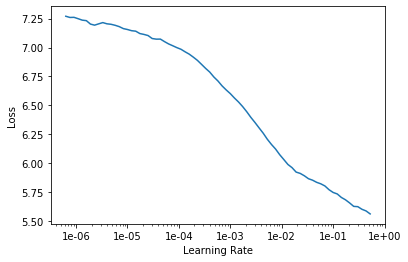

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-3

In [23]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.872753,3.717332,0.143615,0.228012,0.312338,0.223159,0.548665,1.200861,1.060684,01:07
1,3.771329,3.640988,0.142873,0.226362,0.309284,0.219894,0.532687,1.172359,1.037529,01:06
2,3.715627,3.544358,0.140983,0.225408,0.304498,0.212570,0.513536,1.139332,1.008030,01:06
3,3.668299,3.538356,0.152563,0.225008,0.302796,0.212181,0.508457,1.131777,1.005574,01:06
4,3.626444,3.446670,0.145040,0.223813,0.297343,0.205736,0.491683,1.104299,0.978754,01:06
5,3.572670,3.391771,0.139917,0.221956,0.293314,0.203055,0.479922,1.084980,0.968626,01:06
6,3.515852,3.368415,0.138220,0.222251,0.293136,0.201405,0.476065,1.079827,0.957511,01:06
7,3.469927,3.339760,0.142730,0.221260,0.289290,0.198867,0.469812,1.070305,0.947495,01:06
8,3.466629,3.310040,0.138754,0.219074,0.286422,0.197629,0.467442,1.058240,0.942479,01:06
9,3.364935,3.190149,0.137080,0.216640,0.279271,0.190024,0.436408,1.023046,0.907681,01:06


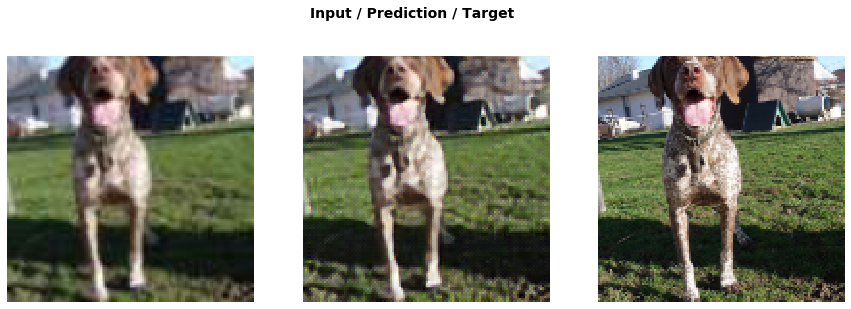

In [24]:
do_fit('1a', slice(lr*10))

In [25]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.342964,3.185119,0.135856,0.215847,0.278349,0.189471,0.438428,1.022310,0.904858,01:09
1,3.355949,3.180934,0.136273,0.215785,0.278195,0.189218,0.436785,1.021418,0.903259,01:09
2,3.348976,3.168796,0.136150,0.215414,0.277474,0.188465,0.435306,1.017329,0.898660,01:09
3,3.336172,3.176070,0.135053,0.215206,0.277149,0.188755,0.439502,1.019904,0.900501,01:09
4,3.324842,3.159425,0.136270,0.215107,0.276938,0.187794,0.433612,1.014986,0.894718,01:09
5,3.324768,3.154551,0.137214,0.215113,0.277055,0.188068,0.429311,1.011629,0.896161,01:09
6,3.308961,3.142357,0.136640,0.214763,0.275814,0.186939,0.428648,1.008743,0.890810,01:09
7,3.297145,3.138903,0.136109,0.214321,0.275551,0.186817,0.428012,1.007551,0.890542,01:09
8,3.302175,3.125259,0.135372,0.214302,0.274625,0.185951,0.426170,1.003271,0.885568,01:09
9,3.267081,3.111224,0.135966,0.213765,0.273796,0.185000,0.422028,1.000021,0.880649,01:09


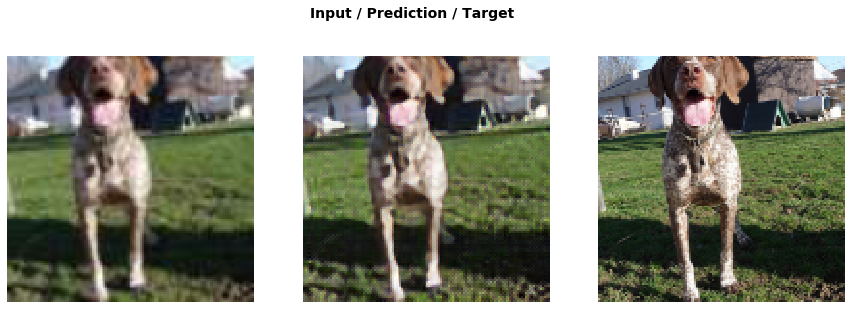

In [26]:
do_fit('1b', slice(1e-5,lr))

In [27]:
data = get_data(12,size*2)

In [28]:
learn.data = data
learn.freeze()
gc.collect()

20995

In [29]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.232810,2.205196,0.162098,0.259736,0.296001,0.155023,0.385273,0.580900,0.366164,04:38
1,2.209673,2.181636,0.162616,0.259649,0.293887,0.153092,0.377782,0.573810,0.360802,04:23
2,2.202606,2.164304,0.164876,0.261255,0.292961,0.152776,0.365299,0.568468,0.358671,04:23
3,2.155216,2.145011,0.165204,0.259921,0.290533,0.151037,0.361457,0.562066,0.354792,04:23
4,2.144748,2.130685,0.166649,0.259506,0.288670,0.149634,0.354528,0.560131,0.351568,04:23
5,2.140885,2.125980,0.166197,0.259119,0.287375,0.149228,0.355908,0.557776,0.350377,04:23
6,2.122833,2.110874,0.164377,0.256651,0.285767,0.147298,0.354239,0.554964,0.347579,04:23
7,2.111763,2.105630,0.166009,0.256746,0.284984,0.147093,0.349673,0.554686,0.346440,04:23
8,2.097960,2.116314,0.169910,0.258280,0.285185,0.147195,0.350333,0.559332,0.346080,04:23
9,2.081570,2.070099,0.165293,0.256538,0.283094,0.146140,0.334803,0.541868,0.342363,04:23


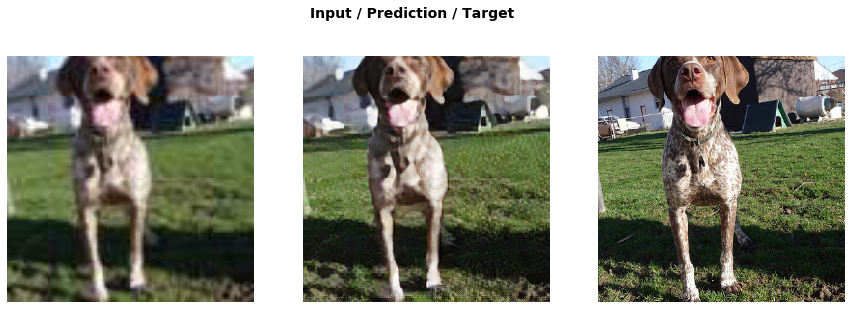

In [30]:
do_fit('2a')

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.072898,2.069217,0.165349,0.256738,0.283072,0.146168,0.334256,0.541348,0.342286,04:34
1,2.072942,2.068466,0.165405,0.256565,0.282982,0.146132,0.334069,0.541143,0.342169,04:34
2,2.063141,2.067085,0.165726,0.256697,0.283023,0.145966,0.332708,0.541185,0.341780,04:34
3,2.070123,2.065329,0.165643,0.256782,0.282888,0.145939,0.332152,0.540423,0.341503,04:34
4,2.050239,2.062248,0.165633,0.256337,0.282427,0.145815,0.331290,0.539533,0.341214,04:34
5,2.060945,2.059801,0.164994,0.255746,0.281779,0.145336,0.332255,0.539410,0.340280,04:34
6,2.057099,2.056571,0.164509,0.255937,0.282069,0.144990,0.330896,0.538549,0.339620,04:34
7,2.068854,2.055878,0.164699,0.255724,0.281596,0.144985,0.331497,0.537781,0.339596,04:34
8,2.049994,2.055190,0.164611,0.255562,0.281600,0.144964,0.331178,0.537806,0.339469,04:34
9,2.040596,2.056467,0.165446,0.255987,0.281841,0.145245,0.330449,0.537601,0.339898,04:34


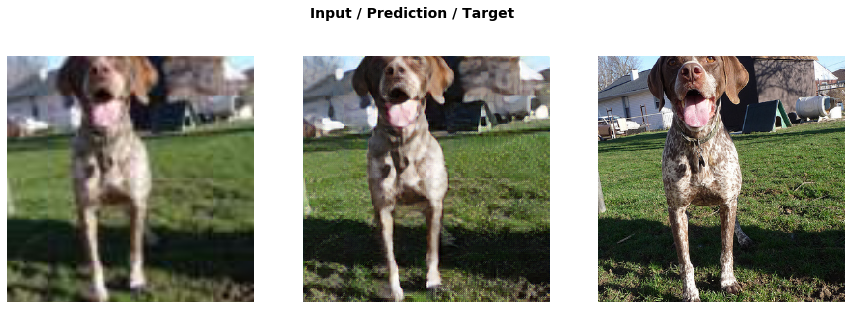

In [32]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [33]:
learn = None
gc.collect();

In [34]:
256/320*1024

819.2

In [35]:
256/320*1600

1280.0

In [36]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 15097MB of GPU RAM free


In [37]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [38]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [39]:
learn.load('2b');

In [40]:
learn.data = data_mr

In [94]:
fn = data_mr.valid_ds.x.items[5]; fn

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-256/Abyssinian_225.jpg')

In [95]:
img = open_image(fn); img.shape

torch.Size([3, 341, 256])

In [96]:
p,img_hr,b = learn.predict(img)

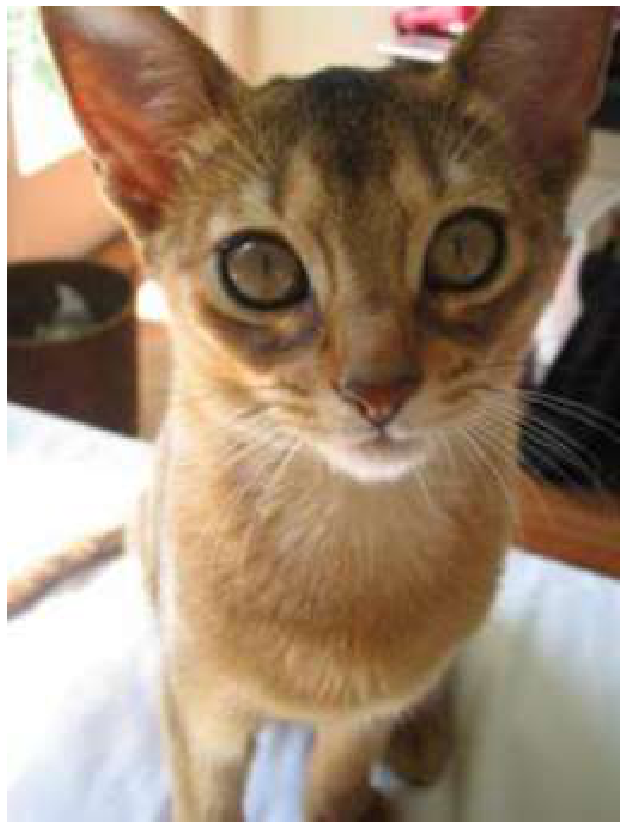

In [97]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


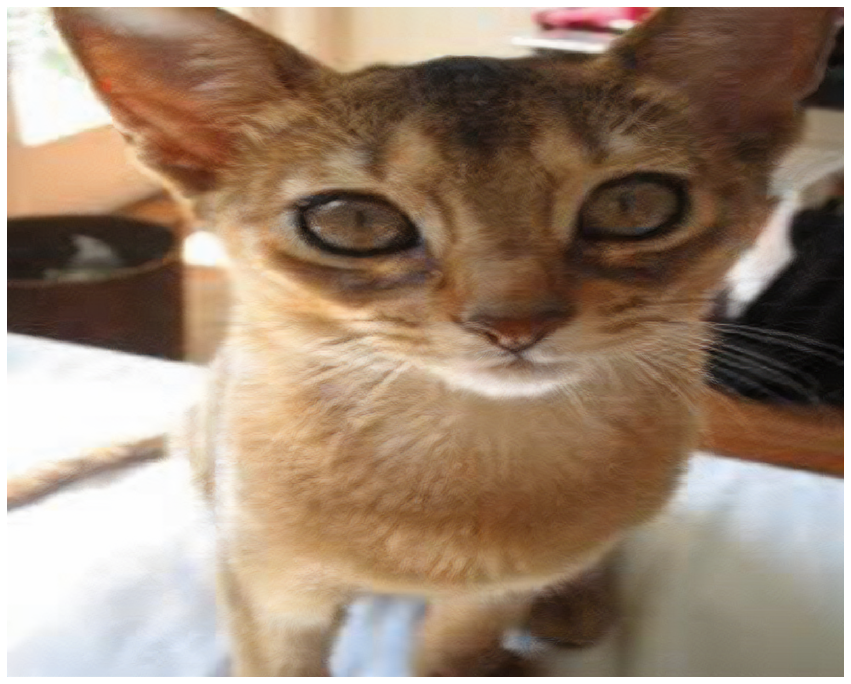

In [114]:
Image(img_hr).show(figsize=(15,25))